# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import pandas as pd
import pprint

# Turn off warnings

import warnings
warnings.filterwarnings('ignore')

Load feature names.

In [2]:
feature_names = []
with open('/Users/alexanderchung/Desktop/amit-coursework/Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:', len(feature_names))

pprint.pprint(feature_names)

Loaded feature names: 126
['cap-shape=bell',
 'cap-shape=conical',
 'cap-shape=convex',
 'cap-shape=flat',
 'cap-shape=knobbed',
 'cap-shape=sunken',
 'cap-surface=fibrous',
 'cap-surface=grooves',
 'cap-surface=scaly',
 'cap-surface=smooth',
 'cap-color=brown',
 'cap-color=buff',
 'cap-color=cinnamon',
 'cap-color=gray',
 'cap-color=green',
 'cap-color=pink',
 'cap-color=purple',
 'cap-color=red',
 'cap-color=white',
 'cap-color=yellow',
 'bruises?=bruises',
 'bruises?=no',
 'odor=almond',
 'odor=anise',
 'odor=creosote',
 'odor=fishy',
 'odor=foul',
 'odor=musty',
 'odor=none',
 'odor=pungent',
 'odor=spicy',
 'gill-attachment=attached',
 'gill-attachment=descending',
 'gill-attachment=free',
 'gill-attachment=notched',
 'gill-spacing=close',
 'gill-spacing=crowded',
 'gill-spacing=distant',
 'gill-size=broad',
 'gill-size=narrow',
 'gill-color=black',
 'gill-color=brown',
 'gill-color=buff',
 'gill-color=chocolate',
 'gill-color=gray',
 'gill-color=green',
 'gill-color=orange',
 'gi

Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('/Users/alexanderchung/Desktop/amit-coursework/Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print (train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
# Run PCA for k in [1,50]

for k in range(1,51):
    pca1 = PCA(n_components=k)
    pca1.fit(train_data)
    sum_ = np.cumsum(pca1.explained_variance_ratio_)
    print ("For k =",k, "fraction explained is" , sum_[len(sum_)-1])

For k = 1 fraction explained is 0.164043312793
For k = 2 fraction explained is 0.297278101488
For k = 3 fraction explained is 0.399012666709
For k = 4 fraction explained is 0.46964623105
For k = 5 fraction explained is 0.508312688903
For k = 6 fraction explained is 0.545120727977
For k = 7 fraction explained is 0.576403025966
For k = 8 fraction explained is 0.603740335761
For k = 9 fraction explained is 0.629905324462
For k = 10 fraction explained is 0.652214347098
For k = 11 fraction explained is 0.672694414527
For k = 12 fraction explained is 0.691378241122
For k = 13 fraction explained is 0.70867672171
For k = 14 fraction explained is 0.725408411673
For k = 15 fraction explained is 0.740684258436
For k = 16 fraction explained is 0.755751255303
For k = 17 fraction explained is 0.77010566415
For k = 18 fraction explained is 0.78398222149
For k = 19 fraction explained is 0.797468054788
For k = 20 fraction explained is 0.808867774898
For k = 21 fraction explained is 0.819596375303
For k

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

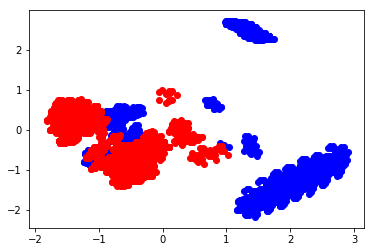

In [5]:
# Criteria for positive and negative

positive = np.equal(train_labels, 1)
negative = np.equal(train_labels, 0)

# Create PCA

pca2 = PCA(n_components=2)
pca2_train = pca2.fit_transform(train_data)

# Slice for positive and negative cases

positive_cases = pca2_train[positive,:]
negative_cases = pca2_train[negative,:]

# Plot

plt.scatter(positive_cases[:,0],positive_cases[:,1], c='#0000FF')
plt.scatter(negative_cases[:,0],negative_cases[:,1], c='#FF0000')

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

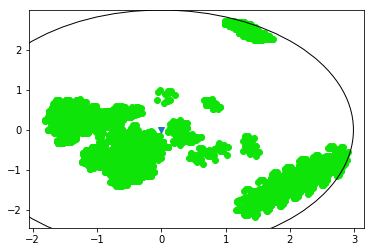

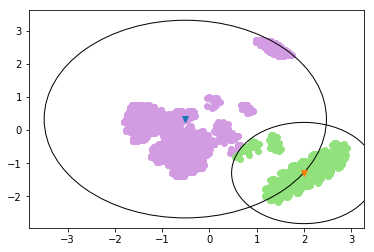

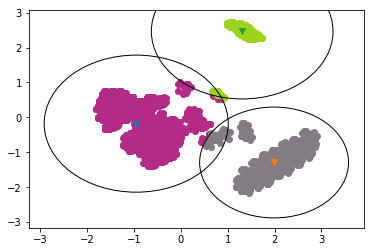

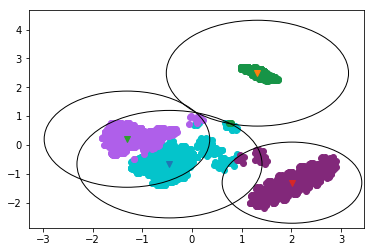

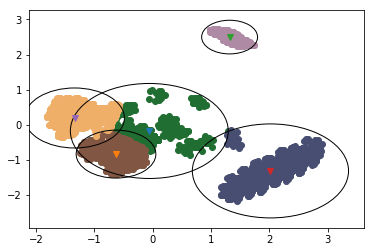

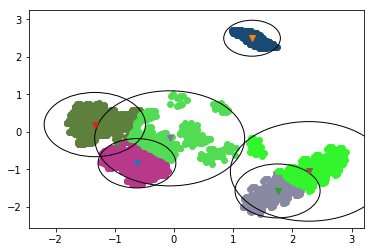

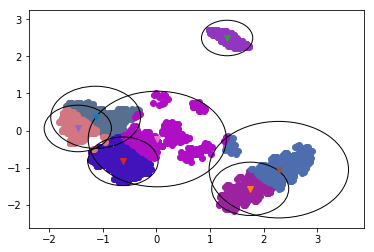

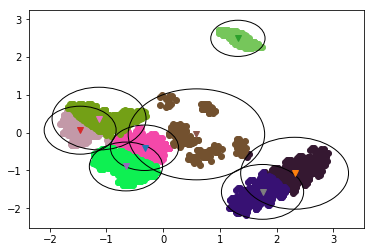

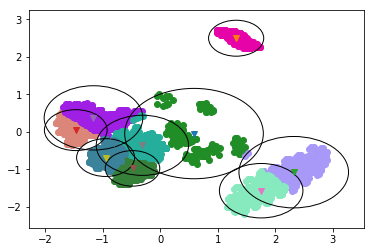

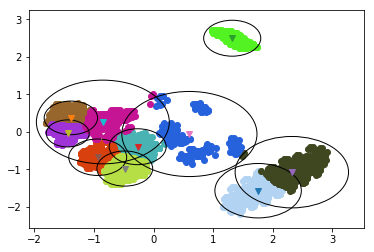

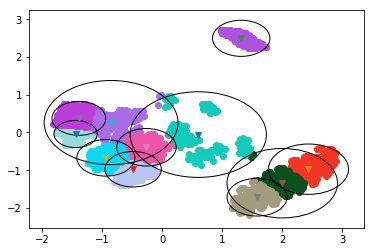

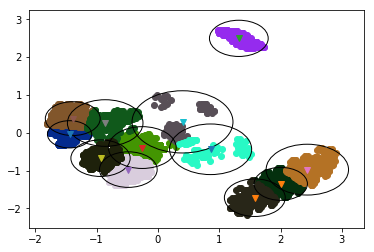

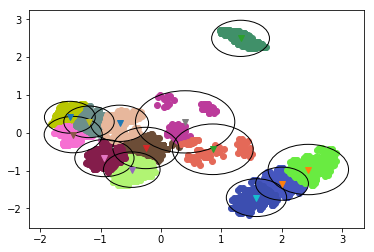

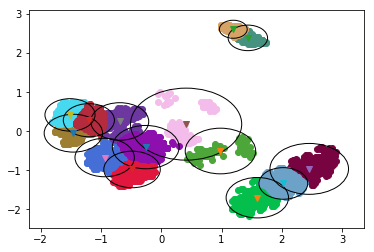

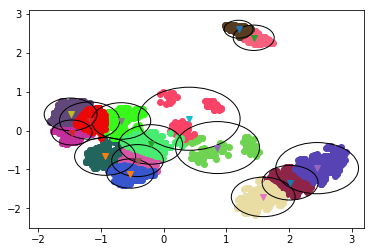

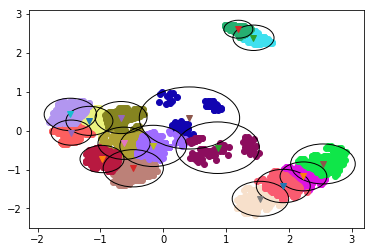

In [6]:
# Create PCA

pca3 = PCA(n_components=2)
pca3_train = pca3.fit_transform(train_data)

# Run KMeans with 1 to 16 clusters

for n in range(1,17):
    
    # Get distances, centers, and labels
    
    km = KMeans(n_clusters=n)
    distances = km.fit_transform(pca3_train)
    centers = km.cluster_centers_
    labels = km.labels_
    
    # Build plots
    
    for idx, center in enumerate(centers):
        
        # Plot data points
        
        plt.scatter(pca3_train[:, 0][labels==idx], pca3_train[:, 1][labels==idx], c=np.random.rand(3,))
        plt.plot(center[0], center[1], marker = 'v')
        
        # Get max distance from center and add circle
        
        cluster = distances[labels==idx]
        max_distance = np.amax(cluster[:,idx])        
        circle = plt.Circle(center, max_distance, fill=False)
        plt.gca().add_patch(circle)
        
    plt.show()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

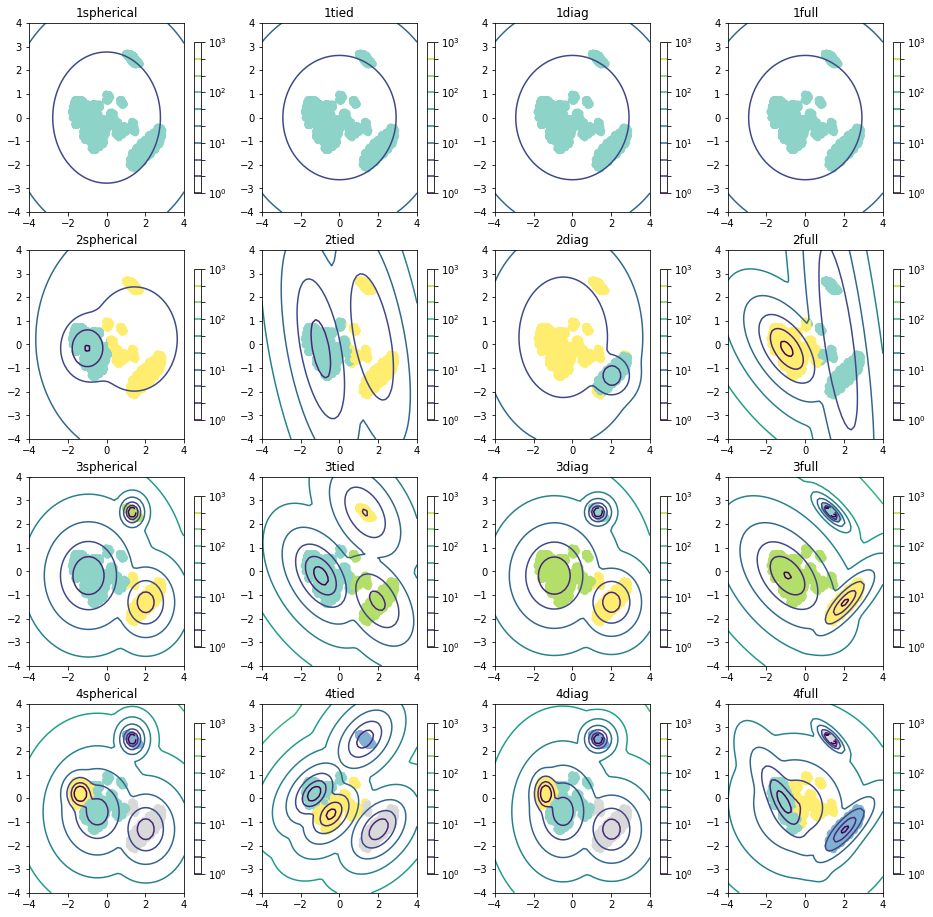

In [7]:
# Create PCA

pca4 = PCA(n_components=2)
pca4_train = pca4.fit_transform(train_data)

# Create canvas for plots
    
cm = plt.cm.get_cmap('Set3')
plt.figure(figsize=(16, 16))
i = 0

# Fit GMMs for each component and covariance type

for n in range(1,5):
    for cov in ['spherical', 'tied', 'diag', 'full']:
        i += 1
        
        # Create GMM
        
        gmm = GMM(n_components=n, covariance_type=cov)
        gmm.fit(pca4_train)            
        gmm_predict = gmm.predict(pca4_train)
        
        # Create contours
        
        x = np.linspace(-4., 4.)
        y = np.linspace(-4., 4.)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gmm.score_samples(XX)[0]
        Z = Z.reshape(X.shape)
        
        # Create plot
        
        p = plt.subplot(4, 4, i)       
        p.scatter(pca4_train[:, 0], pca4_train[:, 1], c=gmm_predict, cmap=cm)   
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),levels=np.logspace(0, 3, 10))
        CB = plt.colorbar(CS, shrink=0.8, extend='both')
            
        plt.title(str(n) + str(cov))

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
# Criteria for positive and negative

positive = np.equal(train_labels, 1)
negative = np.equal(train_labels, 0)

# Create PCA for train and test data

pca5 = PCA(n_components=2)
pca5_train = pca5.fit_transform(train_data)
pca5_test = pca5.transform(test_data)

# Slice for positive and negative cases

positive_cases = pca5_train[positive,:]
negative_cases = pca5_train[negative,:]

# GMM for positive

gmm_positive = GMM(n_components=4,covariance_type='full')
gmm_positive.fit(positive_cases)
score_positive = gmm_positive.score(pca5_test,test_labels)

# GMM for negative

gmm_negative = GMM(n_components=4,covariance_type='full')
tom = gmm_negative.fit(negative_cases)
score_negative = gmm_negative.score(pca5_test,test_labels)

# Explore scores

pos_wins = score_positive > score_negative

df = pd.DataFrame({'Positive Log Probabilities': score_positive, 
                   'Negative Log Probabilities': score_negative, 
                   'Positive Beats Negative': pos_wins})

df['Positive Beats Negative'].value_counts()

True     679
False    445
Name: Positive Beats Negative, dtype: int64

In [9]:
# See accuracy 

predictions = np.where(score_negative>score_positive,0,1)
accuracy = np.sum((predictions == test_labels))/float(len(test_labels))*100
print ("Accuracy = ",accuracy)

Accuracy =  95.1067615658


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [10]:
# Set parameters

pca_components = range(1,6)  # 1 to 5
gmm_components = range(1,11) # 1 to 10
cov_types = ['spherical', 'diag', 'tied', 'full']

# Filter for positive and negative

positive = np.equal(train_labels, 1)
negative = np.equal(train_labels, 0)

# Store results

pca_results = []
gmm_results = []
cov_results = []
accuracy_results = []
total_parameters_results = []

# Produce variations

for pca in pca_components:
    for gmm in gmm_components:
        for cov in cov_types:
            total_parameters = ((pca + gmm) * 2) * 2
            if total_parameters < 50:
                
                # Create PCA
            
                pca6 = PCA(n_components=pca)
                pca6_train = pca6.fit_transform(train_data)
                pca6_test = pca6.transform(test_data)
                
                # Create PCA
                
                positive_cases = pca6_train[positive,:]
                negative_cases = pca6_train[negative,:]
                
                # GMM for positive

                gmm_positive = GMM(n_components=gmm,covariance_type=cov)
                gmm_positive.fit(positive_cases)
                score_positive = gmm_positive.score(pca6_test,test_labels)

                # GMM for negative

                gmm_negative = GMM(n_components=gmm,covariance_type=cov)
                gmm_negative.fit(negative_cases)
                score_negative = gmm_negative.score(pca6_test,test_labels)
                
                # Accuracy
                
                predictions = np.where(score_negative>score_positive,0,1)
                accuracy = np.sum((predictions == test_labels))/float(len(test_labels))*100
                
                # Store results
                
                pca_results.append(pca)
                gmm_results.append(gmm)
                cov_results.append(cov)
                accuracy_results.append(accuracy)
                total_parameters_results.append(total_parameters)              

In [12]:
# Create dataframe

df = pd.DataFrame({'# of PCA': pca_results, 
                '# of GMM': gmm_results, 
                'Covariance Type': cov_results,
                'Accuracy': accuracy_results,
                'Total Parameters': total_parameters_results})

print("Top 20 combinations")
print(df.sort_values('Accuracy', ascending=False).head(20))

print("Bottom 20 combinations")
print(df.sort_values('Accuracy', ascending=False).tail(20))

Top 20 combinations
     # of GMM  # of PCA   Accuracy Covariance Type  Total Parameters
167         5         5  99.021352            full                40
175         7         5  98.843416            full                48
172         7         5  98.843416       spherical                48
171         6         5  98.843416            full                44
147         8         4  98.754448            full                48
163         4         5  98.487544            full                36
174         7         5  98.309609            tied                48
173         7         5  98.309609            diag                48
169         6         5  98.309609            diag                44
168         6         5  98.131673       spherical                44
143         7         4  98.131673            full                44
165         5         5  97.686833            diag                40
161         4         5  97.686833            diag                36
139         6 